# _Python for Scientific Data Analysis_


#  Bayesian Statistics and Markov Chain Monte Carlo methods

## Section 2: Markov Chain Monte Carlo method (continued)


### Putting It All Together with a Professional Code: Emcee

After all this setup and a proof-of-concept with the Metropolis-Hastings algorithm, let's do this again with a professional code.  We will use ``emcee`` to perform MCMC.  
We'll start by initializing the walkers in a phase space region centered around the
maximum likelihood result and then run 5,000 steps of MCMC.

We will then import these packages along with our standard import calls for doing numerical Python and displaying data:

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import corner
import emcee

Re-generate the data ...

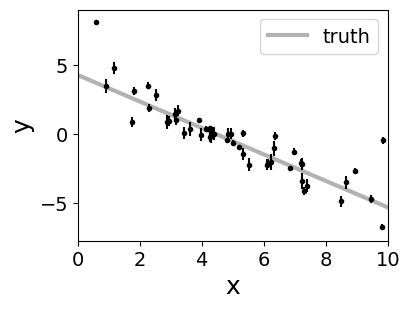

In [37]:
#plt.figure(figsize=(8,6))
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

fig,ax=plt.subplots(figsize=(4,3))

ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3,label="truth")
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel("x",fontsize=18)
ax.set_ylabel("y",fontsize=18)
ax.legend(loc='best',fontsize=14);

#least squares fit
A = np.vander(x, 2) 
C = np.diag(yerr * yerr) 
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))

Define your functions as before ...

In [38]:
def log_prior(theta):
    m, b, log_f = theta
   # if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
    if -5.0 < m < 1.0 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [39]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Then, combining this with the definition of ``log_likelihood`` from above, the full
log-probability function is:

In [40]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Redo the maximum likelihood fit: our starting point for MCMC

(3,)
Maximum likelihood estimates:
m = -1.003
b = 4.528
logf = -0.790


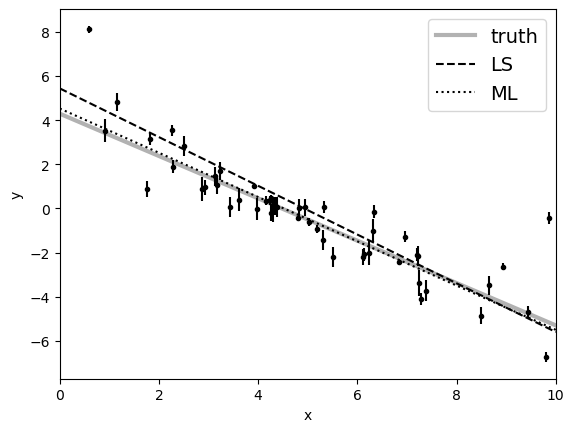

In [41]:
#maximum likelihood fit to parameters
from scipy.optimize import minimize

#np.random.seed(42) #if we comment this out, then the outcome will change each time we run this cell
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.25 * np.random.randn(3)
print(initial.shape)


# Define some range (uniform distributions): i.e. a flat/uninformative prior between these boundary conditions
m_min, m_max = -2.0, -0.5
b_min, b_max = 3,6
#f_min, f_max = 0.0, 1.0
f_min,f_max=-1, 0 #this is actually log(f)

# We need starting points for the maximum-likelihood fit.  Give it something random for each parameter over the allowed phase space.
m_samples = np.random.uniform(m_min, m_max, 1)
b_samples = np.random.uniform(b_min, b_max, 1)
f_samples = np.random.uniform(f_min, f_max, 1)

initial=np.array([m_samples,b_samples,f_samples]).squeeze()

soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("logf = {0:.3f}".format((log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

#print('solx',soln.x)
initial=soln.x

#print(initial.shape)

#print(len(soln.x))

now ... MCMC

In [42]:
#start with ML result (soln.x) + some random number centered on the ML value.  

spreadval=1e-2
nwalkers=50
ndim=3 # for m,b, and log(f)
pos = soln.x + spreadval * np.random.randn(nwalkers, ndim) 
pos[:,0]
print("starting positions for m, b, and log(f) are \n {0}, {1}, {2}".format(pos[:,0],pos[:,1],pos[:,2]))


starting positions for m, b, and log(f) are 
 [-1.00330837 -1.02287699 -1.00624396 -1.00269676 -1.00310267 -0.99760482
 -1.00885768 -0.98562274 -1.00670317 -1.00285346 -1.0162481  -1.01061029
 -0.99446028 -0.9997233  -1.01723025 -1.00383772 -0.99418263 -1.00375466
 -0.99408835 -0.99918393 -0.99286598 -1.00160447 -0.99668613 -0.99512327
 -1.01567079 -1.00083679 -0.99255484 -1.00982373 -0.99601756 -1.00913481
 -1.00646055 -1.00389348 -1.00622073 -1.00097339 -1.02280701 -1.01003496
 -0.98679858 -0.99748414 -0.99859626 -0.99772785 -1.00489125 -1.0016934
 -0.99246034 -0.99724169 -1.00462929 -1.01498988 -1.00694691 -0.99996964
 -1.00569333 -0.99897774], [4.52752745 4.52855148 4.52779481 4.53210985 4.52043908 4.52787058
 4.52238809 4.52374836 4.52913312 4.51084443 4.52571782 4.51811613
 4.53385988 4.5169185  4.53222632 4.53373096 4.52600965 4.5271869
 4.55174988 4.51376096 4.51539861 4.53525413 4.52663125 4.52796261
 4.53067425 4.53647985 4.51658116 4.54160004 4.51454887 4.51731449
 4.5339043

Now, let's run MCMC...

In [43]:
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True); #this should take no more than about 15s on your computer

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2286.40it/s]


Let's take a look at what the sampler has done.
A good first step is to look at the time series of the parameters in
the chain.
The samples can be accessed using the {func}`EnsembleSampler.get_chain` method.
This will return an array
with the shape `(5000, nwalker, ndim)` giving the parameter values for each walker
at each step in the chain.
The figure below shows the positions of each walker as a function of the
number of steps in the chain:

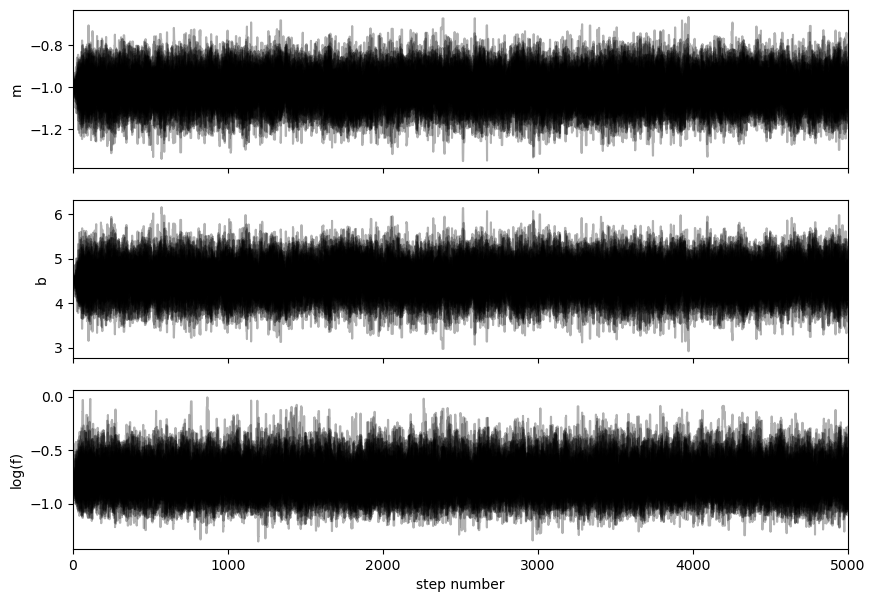

In [45]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.set_xlabel("step number");
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

As mentioned above, the walkers start in small distributions around the
maximum likelihood values and then they quickly wander and start exploring the
full posterior distribution.
In fact, after fewer than 50 steps, the samples seem pretty well "burnt-in".
That is a hard statement to make quantitatively, but we can look at an estimate
of the integrated autocorrelation time (see the {ref}`autocorr` tutorial for more details):

In [46]:
tau = sampler.get_autocorr_time()
print(tau)

[37.03993343 37.59874701 35.51531922]


This suggests that $<$100 steps are needed for the chain to "forget" where it started.
It's not unreasonable to throw away a few times this number of steps as "burn-in".
Let's discard the initial 100 steps, thin by about half the autocorrelation time, and flatten the chain (i.e. instead of a dimension of nwalkerxndim (~50x3=150) we have 150,1 so that we have a flat list of samples:

In [51]:
gg=sampler.get_chain()
print(gg.shape)
#flat_samples = sampler.get_chain(discard=100, thin=35, flat=True)
#flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
flat_samples=sampler.get_chain(flat=True)
#flat_samples = sampler.get_chain(discard=100, thin=15) flat_sample.shape = (326,32,3)
print(flat_samples.shape) 

(5000, 50, 3)
(250000, 3)


### Results

Now that we have this list of samples, let's make a corner plot using ``corner.py``.

Here, we overplot the quantiles and give labels.

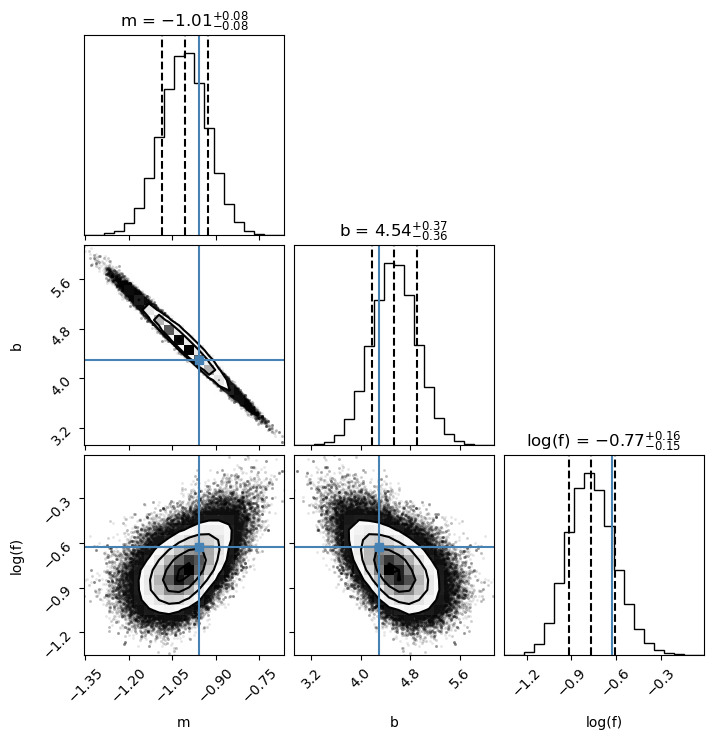

In [52]:
fig = corner.corner(flat_samples,show_titles=True,truths=[m_true, b_true, np.log(f_true)],
                     labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

To more significant figures, the 50% quantile (and 68% CI) values are ...

In [49]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The corner plot shows all the one and two dimensional projections of the
posterior probability distributions of your parameters.
This is useful because it quickly demonstrates all of the covariances between
parameters.
Also, the way that you find the marginalized distribution for a parameter or
set of parameters using the results of the MCMC chain is to project the
samples into that plane and then make an N-dimensional histogram.
That means that the corner plot shows the marginalized distribution for each
parameter independently in the histograms along the diagonal and then the
marginalized two dimensional distributions in the other panels.

Now we can project our results into the space of
the observed data.
To do this, you can choose a few (say 100 in this case) samples from the chain
and plot them on top of the data points:

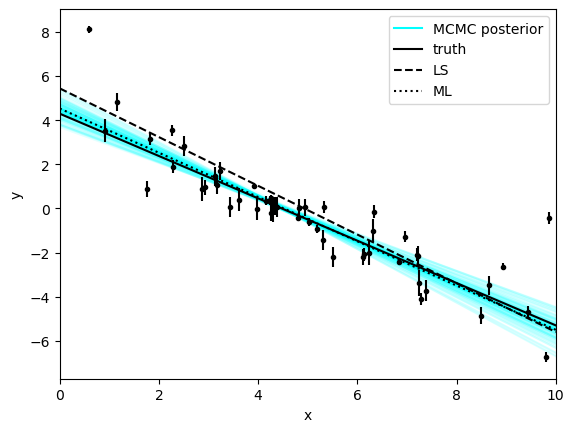

In [50]:
inds = np.random.randint(len(flat_samples), size=100)

sample0=flat_samples[0]
plt.plot(x0, np.dot(np.vander(x0, 2), sample0[:2]), color='cyan', alpha=1,label='MCMC posterior')
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), color='cyan', alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best');

As you can see, the simple LS solution is way off for small values of x.   And MCMC gives us a better idea of the certainty around the best-fit model (which is close to the ML solution).

And there you have it: a simple demonstration of MCMC with the ``emcee`` package.


### Burn-In, AutoCorrelation, and Thinning

#### _Burn In_

Our initial starting position for the Markov chains looks very reasonable by eye.  What happens if we make them very much not reasonable?  See how the Markov chains find there way back to regions of highest likelihood.

[to show, just redo the initial ML fit]

(3,)
Maximum likelihood estimates:
m = -0.737
b = 2.696
logf = 0.247


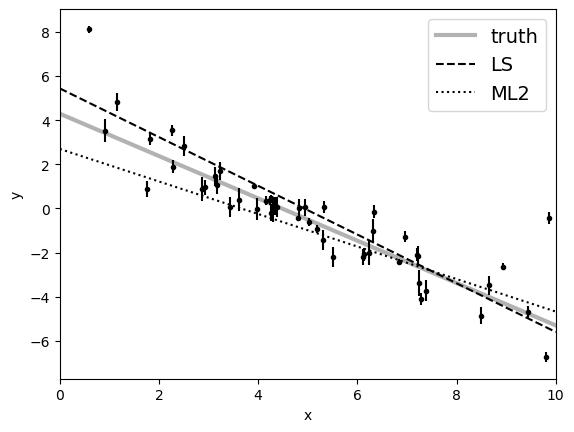

In [59]:
#purposefully throw the max-likelihood values off...

#maximum likelihood fit to parameters
from scipy.optimize import minimize

#np.random.seed(42) #if we comment this out, then the outcome will change each time we run this cell
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.25 * np.random.randn(3)
print(initial.shape)


# Define some range (uniform distributions): i.e. a flat/uninformative prior between these boundary conditions
m_min2, m_max2 = -2.0, 0.5
b_min2, b_max2 = 3,10
#f_min, f_max = 0.0, 1.0
f_min2,f_max2=-1, 0 #this is actually log(f)

# We need starting points for the maximum-likelihood fit.  Give it something random for each parameter over the allowed phase space.
m_samples2 = np.random.uniform(m_min2, m_max2, 1)
b_samples2 = np.random.uniform(b_min2, b_max2, 1)
f_samples2 = np.random.uniform(f_min2, f_max2, 1)

initial=np.array([m_samples2,b_samples2,f_samples2]).squeeze()

soln2 = minimize(nll, initial, args=(x, y, yerr))
m_ml2, b_ml2, log_f_ml2 = soln2.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml2))
print("b = {0:.3f}".format(b_ml2))
print("logf = {0:.3f}".format((log_f_ml2)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml2, b_ml2]), ":k", label="ML2")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");



In [80]:
def log_prior(theta):
    m, b, log_f = theta
   # if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
    if -5.0 < m < 1.0 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


#start with ML result (soln.x) + some random number centered on the ML value.  

spreadval=1e-2
nwalkers=50
ndim=3 # for m,b, and log(f)
pos2 = soln2.x + spreadval * np.random.randn(nwalkers, ndim) 



In [81]:
nwalkers2, ndim2 = pos2.shape
nsamples = 10000 #lets run this for longer

samplerv2 = emcee.EnsembleSampler(
    nwalkers2, ndim2, log_probability, args=(x, y, yerr)
)
samplerv2.run_mcmc(pos2, 10000, progress=True); #this should take no more than about 15s on your computer

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2069.65it/s]


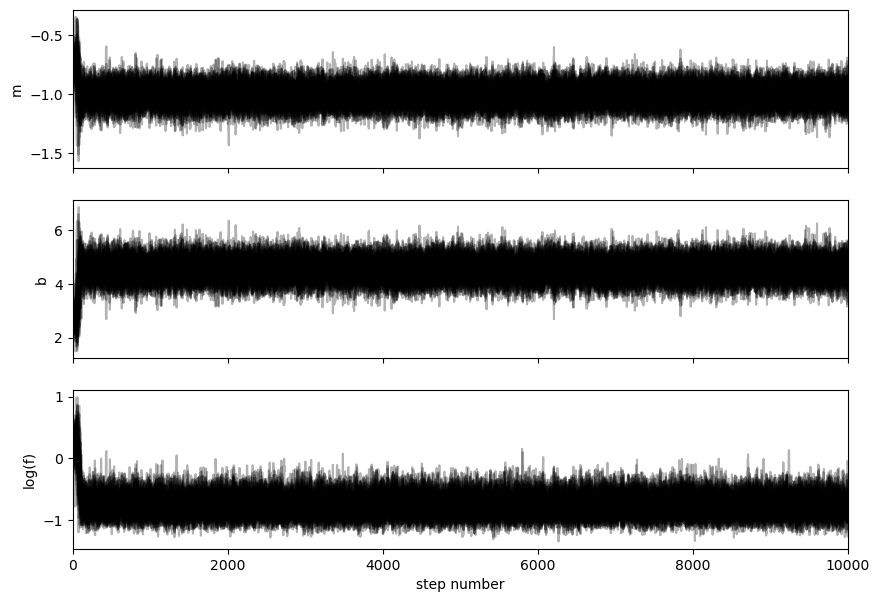

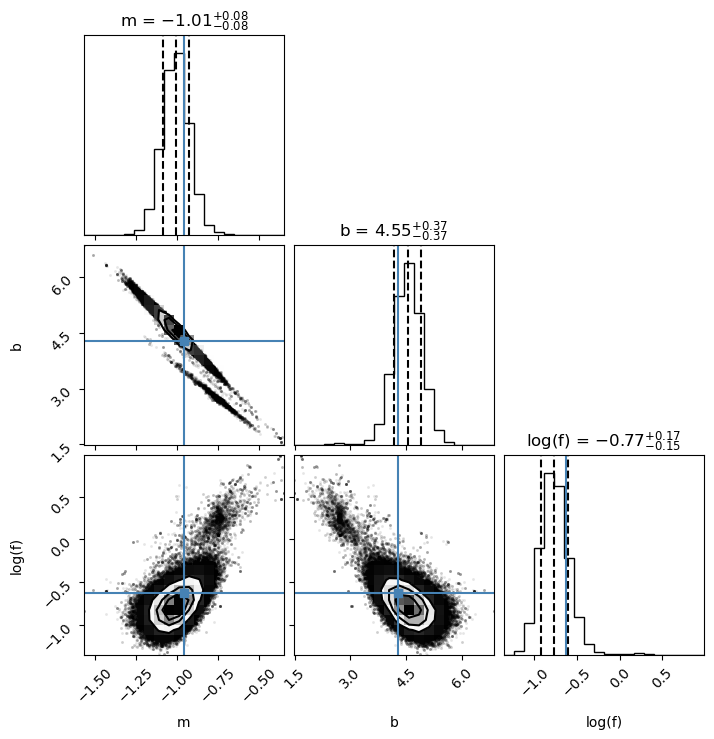

In [82]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samplesv2 = samplerv2.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samplesv2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samplesv2))
    ax.set_ylabel(labels[i])
    #ax.set_xlabel("step number");
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

flat_samples2=samplerv2.get_chain(flat=True)

fig = corner.corner(flat_samples2,show_titles=True,truths=[m_true, b_true, np.log(f_true)],
                     labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

As is clear in the above example, we started in some parameter space set by our skewed ML solution that obviously does not reflect the true parameter value.  The Markov chains take some time to find themselves in high-probability regions.  

This is called the ``burn-in`` period.   These particular samples should not be used to estimate parameter posterior distributions. Therefore, we need to "trim" the burn-in period before deriving posteriors.  From visual inspection, we should probably discard the first 100 steps.

#### _AutoCorrelation_ 

Additionally, remember that a Markov Chain is a sequence of random variables whose probability at a given time $t+1$ only depends on the variables at time $t$.  One way of restating this, though, is that the value at time $t+1$ is well correlated/not independent from the value at time $t$.   Ideally, we would like to have completely independent samples of the high likelihood regions of parameter posterior distributions.   

The _autocorrelation_ timescale measures this: i.e. how many steps you must skip before the samples are effectively independent.  When the autocorrelation timescale $\tau$ is small (tens of steps), the chain mixes well. When $\tau$ is large, you need longer chains (i.e. more steps) or a better proposal distribution.

The details of how to calculate the autocorrelation time for each parameter are a bit messy: for this class, just know how to call the function.  



In [83]:
tau = samplerv2.get_autocorr_time()
print(tau)
print(samplesv2.shape)
dims=samplesv2.shape
N_eff = np.float64(dims[0])/ (2 * tau)
print('the number of effectively independent samples is ',np.round(N_eff).astype(int))


[39.79377808 42.60384033 50.59074722]
(10000, 50, 3)
the number of effectively independent samples is  [126 117  99]


We get autocorrelation timescales of 65-112 steps.

If you calculate the autocorrelation timescale you might get an error message like this:
```
AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
```

Generally speaking, you want to have chains that are at least 50 times the integrated autocorrelation time for each parameter.  If you get this error, you should run your chains for more steps.  E.g. if I chose 5000 steps instead of 10,000 steps I sometimes get them in this example.
   
Now, let's combine the burn-in and autocorrelation information to adjust our chains.  The syntax to this this within ``emcee`` is to "discard" a certain number of steps for burn-in.  Then "thin" the chains by some fraction of the typical autocorrelation timescale: one often-used approach is to thin by half the autocorrelation timescale.  So let's thin by, say, 50.

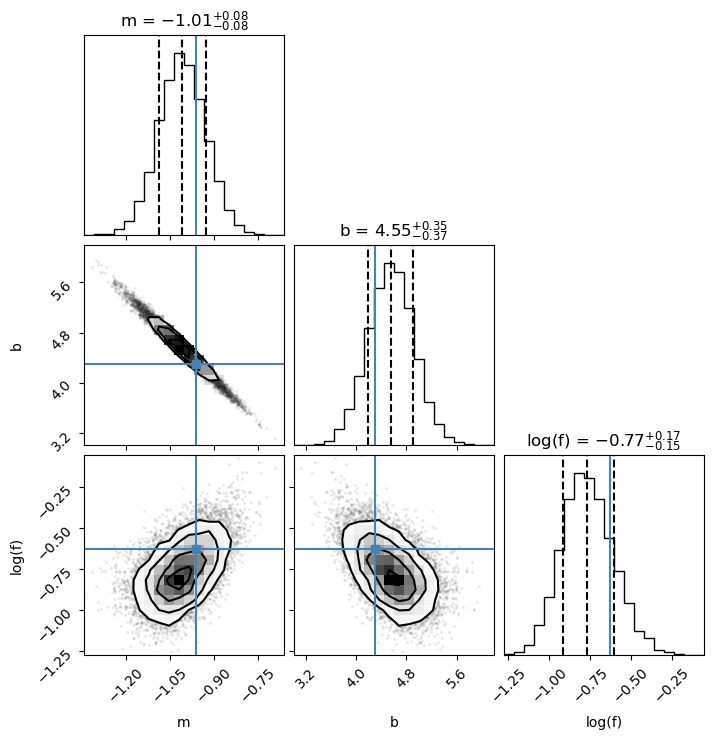

In [84]:
#flat_samples3=samplerv2.get_chain(discard=100,flat=True) #just burn-in
#flat_samples3=samplerv2.get_chain(thin=50,flat=True) #just thinning
flat_samples3=samplerv2.get_chain(discard=100,thin=50,flat=True) #burn-in + thinning

fig = corner.corner(flat_samples3,show_titles=True,truths=[m_true, b_true, np.log(f_true)],
                     labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

We recover basically the same answers we got before with MCMC without intentionally skewing our starting positions for ``emcee``.

#### _Gelman-Rubin Statistic/Test of Convergence_

In [ ]:
def gelman_rubin(chains):
    """
    Compute Gelman-Rubin R-hat for an array of shape (nchains, nsteps, ndim).
    Returns an array of length ndim.
    """
    nsteps, nchains, ndim = chains.shape

    # split chains in half (to reduce autocorrelation bias)
    half = nsteps // 2
    chains = chains[half:, :, :]

    # recompute shape after trimming
    nsteps, nchains, ndim = chains.shape

    # per-dimension mean and variance
    chain_means = np.mean(chains, axis=0) #
    chain_vars  = np.var(chains, axis=0, ddof=1)

    # between-chain variance
    B = nsteps * np.var(chain_means, axis=0, ddof=1)

    # within-chain variance
    W = np.mean(chain_vars, axis=0)

    # estimated target variance
    Var_hat = ( (nsteps - 1)/nsteps ) * W + B/nsteps

    # Gelman-Rubin statistic
    Rhat = np.sqrt(Var_hat / W)
    return Rhat

reg_chain=samplerv2.get_chain(discard=100) #burn-in + thinning



result=gelman_rubin(reg_chain)
print(result)

Typical interpretation:

R-hat $\approx$ 1.00–1.05: converged

R-hat = 1.05–1.1: needs more sampling

R-hat $>$ 1.1: chains have not mixed

R-hat is complementary to autocorrelation time.  Autocorrelation tells you how efficient your samples are, while R-hat tells you whether multiple walkers are settling on the same distribution.

Based on the above statistics, our chains have converged.

In the next section, we will go through a more complex example resembling a more realistic scientific problem where the dimensionality increases and the posteriors can be multimodal.  

And finally, we will have a homework problem focused on a simple MCMC simulation, which I will hopefully post later today or tomorrow.